In [1]:
import datetime
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 
from uuid import uuid4
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    

os.chdir(r'C:\Users\User\GitHub\WebET_Analysis')
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


# Read data

In [2]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

print(pd.DataFrame([[len(data_et)], [len(data_trial)], [len(data_subject)]], 
                   columns=['length'],
                   index=['data_et', 'data_trial', 'data_subject'])
     )

               length
data_et       2700001
data_trial     133206
data_subject      212


# Missing eye-tracking values

In [3]:
data_et.loc[
    pd.isna(data_et['x']) |
    pd.isna(data_et['y']), 
    :
]

,x,y,t,t_task,run_id,trial_index


In [4]:
data_et = data_et.loc[
    pd.notna(data_et['x']) |
    pd.notna(data_et['y']), 
    :
]

# Cleaning: Filter approved subject (approved by prolific)

Unapproved trials are either not from Prolific, or returned

In [5]:
subjects_notApproved = data_subject.loc[
    ~data_subject['status'].isin(['APPROVED']),
    'prolificID'
].unique()

data_not_approved = data_subject.loc[
    data_subject['prolificID'].isin(subjects_notApproved),
    ['run_id', 'prolificID', 'max_trial', 'recorded_date', 'status']
]

data_subject = data_subject.loc[
    ~data_subject['run_id'].isin(subjects_notApproved),
    :
]

print(
    f"""N Subjects that are not approved: {len(subjects_notApproved)} """
    f"""= {round(100 * len(subjects_notApproved) / len(data_subject['run_id'].unique()), 2)}%"""
)

data_not_approved.head(5)

N Subjects that are not approved: 0 = 0.0%


,run_id,prolificID,max_trial,recorded_date,status


In [6]:
data_et = data_et.loc[
    ~data_et['run_id'].isin(data_not_approved['run_id']), 
    :
]
len(data_et['run_id'].unique())

252

# Dropouts (on run level)

Most subjects drop out before the eye-tracking tasks begins

## By task nr

In [7]:
def dropout_task_nr(data):
    grouped_trial_type_new = data \
        .loc[: , ['run_id', 'trial_index', 'task_nr_new']] \
        .drop_duplicates()

    last_trial_for_each_subject = data \
        .groupby(['run_id'])['trial_index'].max() \
        .reset_index() \
        .merge(grouped_trial_type_new, on=['run_id', 'trial_index'], how='left') \
        .loc[:, ['run_id', 'task_nr_new']]
        
    dropout_by_type = last_trial_for_each_subject \
        .groupby(['task_nr_new'])['run_id'].count() \
        .reset_index() \
        .rename(columns={'run_id': 'n_run_id'}) \
        .sort_values(by='n_run_id')
    
    return dropout_by_type

dropout_task_nr(data_trial)

,task_nr_new,n_run_id
1,1,1
2,2,5
0,0,65
3,3,245


## By trial type
Most runs drop out at the beginning (8.8% chinFirst +7.2% no chinFirst), in detail, during the initialization of Webgazer (4.4%+3.2%), during the calibration instruction (0.6%+2.5%) and the calibration itself (1.2+0.3%). Moreover, some dropouts during the tasks (0.6+1.8%).

In [8]:
grouped_last_trial = data_trial.groupby(['run_id'])['trial_index'].max() \
    .reset_index() \
    .merge(
        data_trial.loc[:, ['run_id', 'trial_index', 'prolificID', 'trial_type_nr', 'trial_type_new']], 
        on=['run_id', 'trial_index'], 
        how='left'
    )

grouped_last_trial_dropout = grouped_last_trial.loc[
    grouped_last_trial['trial_type_new']!='end', 
    :
]

runs_dropout = grouped_last_trial_dropout['run_id']

print(
    f"""N Runs with dropout: n={len(runs_dropout)}"""
    f""" = {round(100 * len(runs_dropout) / len(data_trial['run_id'].unique()), 2)}%""")

N Runs with dropout: n=73 = 23.1%


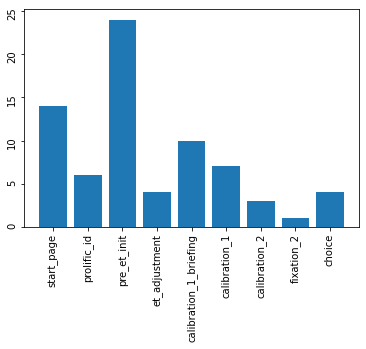

In [9]:
data = grouped_last_trial_dropout \
    .groupby(['trial_type_nr', 'trial_type_new'], as_index=False)['run_id'].count() \
    .rename(columns={'run_id': 'n'})

fig, ax = plt.subplots()
ax.bar(data['trial_type_new'], data['n'])

for ax in fig.axes:
    ax.tick_params(labelrotation=90)

## By upcoming trial
Most runs drop out at the beginning (8.8% chinFirst +7.2% no chinFirst), in detail, during the initialization of Webgazer (4.4%+3.2%), during the calibration instruction (0.6%+2.5%) and the calibration itself (1.2+0.3%). Moreover, some dropouts during the tasks (0.6+1.8%).

In [10]:
def add_next_trial(data):
    full_trials_no_chin = data_trial.loc[
        data_trial['run_id']==421, 
        ['trial_index', 'trial_type', 'trial_type_new']
    ].reset_index(drop=True)

    next_trials_no_chin = full_trials_no_chin
    next_trials_no_chin['trial_index'] -= 1

    full_trials_chin = data_trial.loc[
        data_trial['run_id']==270, 
        ['trial_index', 'trial_type', 'trial_type_new']
    ].reset_index(drop=True)

    next_trials_chin = full_trials_chin
    next_trials_chin['trial_index'] -= 1
    
    data = data.copy()
    data['next_trial_type']=0
    data['next_trial_type_new']=0

    for i in data.index:
        this_trial = data.loc[i, 'trial_index']

        if data.loc[i, 'trial_type_new'] != 'end':
            next_trials = next_trials_chin if data.loc[i, 'chinFirst']>0 else next_trials_no_chin
            
            next_trial = next_trials.loc[
                next_trials['trial_index']==this_trial,
                'trial_type'
            ].values[0]
            data.loc[i, 'next_trial_type']=next_trial

            next_trial = next_trials.loc[
                next_trials['trial_index']==this_trial,
                'trial_type_new'
            ].values[0]
            data.loc[i, 'next_trial_type_new']=next_trial
            
        else:
            data.loc[i, 'next_trial_type']='end'
            data.loc[i, 'next_trial_type_new']='end'
            
    return data

grouped_trial_type_new = data_trial \
        .loc[: , ['run_id', 'chinFirst', 'trial_index', 'trial_type_new']] \
        .drop_duplicates()

last_trial_for_each_run = data_trial \
    .groupby(['run_id'])['trial_index'].max() \
    .reset_index() \
    .merge(grouped_trial_type_new, on=['run_id', 'trial_index'], how='left')

last_trial_for_each_run = add_next_trial(last_trial_for_each_run)
last_trial_for_each_run

,run_id,trial_index,chinFirst,trial_type_new,next_trial_type,next_trial_type_new
0,1,518,1,end,end,end
1,3,0,1,start_page,html-button-response,start_page
2,4,519,0,end,end,end
3,5,519,1,end,end,end
4,6,519,0,end,end,end
...,...,...,...,...,...,...
311,457,4,1,pre_et_init,eyetracking-init,et_init
312,458,536,0,end,end,end
313,459,4,0,pre_et_init,eyetracking-init,et_init
314,460,4,1,pre_et_init,eyetracking-init,et_init


In [11]:
dropout_by_type = last_trial_for_each_run \
    .groupby(['trial_type_new', 'next_trial_type_new', 'next_trial_type']).count() \
    .reset_index() \
    .rename(columns={'run_id': 'n_run_id'}) \
    .loc[
        :, 
        [
           'trial_type_new', 'next_trial_type_new', 'next_trial_type', 'n_run_id', 
        ]
    ] \
    .sort_values(by='n_run_id')

dropout_by_type['perc'] = round(
    100 * dropout_by_type['n_run_id'] / len(data_trial['run_id'].unique()), 
    1
)

dropout_by_type

,trial_type_new,next_trial_type_new,next_trial_type,n_run_id,perc
4,calibration_2,calibration_2,html-keyboard-response,1,0.3
9,et_adjustment,et_adjustment,html-keyboard-response,1,0.3
10,fixation_2,fixation_2,html-keyboard-response,1,0.3
0,calibration_1,calibration_1,eyetracking-calibration,2,0.6
3,calibration_2,calibration_2,eyetracking-calibration,2,0.6
5,choice,choice,eyetracking-fix-object,2,0.6
6,choice,choice,html-keyboard-response,2,0.6
8,et_adjustment,et_adjustment,html-button-response,3,0.9
1,calibration_1,calibration_1,html-keyboard-response,5,1.6
12,prolific_id,pre_et_init,html-button-response,6,1.9


In [12]:
summary = pd.DataFrame([
    [
        'beginning',
        sum(
            dropout_by_type.loc[
            dropout_by_type['next_trial_type_new'].isin([
                'pre_et_init',
                'et_init', 
                'et_adjustment',
                'calibration_1_briefing',
                'calibration_1',
            ]),
        'n_run_id']),
        sum(dropout_by_type.loc[
            dropout_by_type['next_trial_type_new'].isin([
                'pre_et_init',
                'et_init', 
                'et_adjustment',
                'calibration_1_briefing',
                'calibration_1',
            ]),
            'perc'])
    ], 
            [
        'et_tasks', 
        sum(dropout_by_type.loc[
            dropout_by_type['next_trial_type_new'].isin([
                'fixation_1',
                'fixation_2',
                'calibration_2',
                'choice',
            ]),
            'n_run_id']),
        sum(dropout_by_type.loc[
            dropout_by_type['next_trial_type_new'].isin([
                'fixation_1',
                'fixation_2',
                'calibration_2',
                'choice',
            ]),
            'perc'])
    ],
    [
        'total',
        sum(dropout_by_type['n_run_id']),
        sum(dropout_by_type['perc'])
    ]
], columns=['type', 'sum', 'perc'])
summary

,type,sum,perc
0,beginning,51,16.1
1,et_tasks,8,2.4
2,total,316,99.8


## Anything unusual at the beginning of the calibration? 

The last trial during calibration varies. There no one 'first calibration' or similar, when the subjects drop out 

In [13]:
data = data_trial

grouped_trial_type_new = data \
    .loc[: , ['run_id', 'trial_index', 'chinFirst', 'trial_type_new']] \
    .drop_duplicates()

last_trial_for_each_subject = data \
    .groupby(['run_id'])['trial_index'].max() \
    .reset_index() \
    .merge(grouped_trial_type_new, on=['run_id', 'trial_index'], how='left')

last_trial_for_each_subject = add_next_trial(last_trial_for_each_subject)

last_trial_for_each_subject.loc[
    last_trial_for_each_subject['next_trial_type_new']=='calibration_1',
    ['run_id', 'trial_index', 'chinFirst', 'trial_type_new', 'next_trial_type_new', 'next_trial_type']
]

,run_id,trial_index,chinFirst,trial_type_new,next_trial_type_new,next_trial_type
68,141,19,0,calibration_1,calibration_1,eyetracking-calibration
127,221,19,1,calibration_1,calibration_1,eyetracking-calibration
135,229,90,0,calibration_1,calibration_1,html-keyboard-response
191,300,28,0,calibration_1,calibration_1,html-keyboard-response
212,332,26,0,calibration_1,calibration_1,html-keyboard-response
245,374,18,0,calibration_1,calibration_1,html-keyboard-response
299,443,70,0,calibration_1,calibration_1,html-keyboard-response


#  Duplicate Prolific ID's - Multiple participations
Most subjects, who had to redo, previously dropped out during calibration briefing (n=7) and the initialization (n=11) multiple times

## How many of the dropouts try again? 

In [14]:
grouped_last_trial_full = grouped_last_trial.loc[
    grouped_last_trial['trial_type_new']=='end', 
    :
]

subjects_multiple_attempts = []
subjects_actual_dropouts = []

for ID in grouped_last_trial_dropout.loc[
        pd.notna(grouped_last_trial_dropout['prolificID']),
        'prolificID'
    ].unique():
    previous_attempt = grouped_last_trial_full.loc[
        grouped_last_trial_full['prolificID'] == ID,
        :
    ]
    if len(previous_attempt)>0:
        subjects_multiple_attempts = np.append(
            subjects_multiple_attempts, ID)
    else:
        subjects_actual_dropouts = np.append(
            subjects_actual_dropouts, ID)

print(
    f"""Of those subjects where the ID is known: n={len(data_subject)}\n"""
    f"""Subjects_multiple_attempts: n={len(subjects_multiple_attempts)}"""
    f""" = {round(100 * len(subjects_multiple_attempts) / len(data_subject), 2)}% \n"""
    f"""subjects_actual_dropouts: n={len(subjects_actual_dropouts)}"""
    f""" = {round(100 * len(subjects_actual_dropouts) / len(data_subject), 2)}% \n"""    
)

Of those subjects where the ID is known: n=212
Subjects_multiple_attempts: n=12 = 5.66% 
subjects_actual_dropouts: n=34 = 16.04% 



## Multiple participation by trial type
Most of the participants, who try again, reload at the beginning of the experiment

In [15]:
duplicate_subjects = data_trial \
    .loc[:, ['prolificID', 'run_id']] \
    .drop_duplicates() \
    .groupby(['prolificID'], as_index=False)['run_id'].count() \
    .rename(columns={'run_id': 'n'})
duplicate_subjects = duplicate_subjects \
    .loc[duplicate_subjects['n']>1, 'prolificID'] \
    .unique()

runs_max_trial = data_trial.loc[data_trial['prolificID'].isin(duplicate_subjects), :] \
    .groupby(['prolificID', 'run_id'], as_index=False)['trial_index'].max() \
    .merge(
        data_trial.loc[
            :, 
            ['run_id', 'chinFirst', 'trial_index', 'trial_type', 'trial_type_nr', 'trial_type_new']
        ], 
        on=['run_id', 'trial_index'], 
        how='left')
runs_max_trial = runs_max_trial \
    .loc[runs_max_trial['trial_type_new']!='end', :]

runs_max_trial= add_next_trial(runs_max_trial)

runs_max_trial \
    .groupby(['next_trial_type_new']).nunique()['prolificID'] \
    .reset_index() \
    .sort_values(by='prolificID')

,next_trial_type_new,prolificID
2,choice,1
5,pre_et_init,1
0,calibration_1,2
3,et_adjustment,2
1,calibration_1_briefing,7
4,et_init,11


# Cleaning

## Remove duplicate Prolific IDs

### data_trial

In [16]:
duplicate_rows = data_trial \
    .loc[:, ['prolificID', 'run_id']] \
    .duplicated() \
    .sum()

trial_index_mean = data_trial \
    .groupby(['prolificID', 'run_id'], as_index=False)['trial_index'].max() \
    .loc[:, 'trial_index'] \
    .mean()

print(f'Number of duplicate rows: {duplicate_rows}')
print(f'Average max trial index: {round(trial_index_mean, 1)}')

Number of duplicate rows: 132890
Average max trial index: 440.0


In [17]:
last_trial_by_run = data_trial \
    .groupby(['prolificID', 'run_id'], as_index=False)['trial_index'].max() \
    .sort_values(by=['prolificID', 'trial_index', 'run_id']) \
    .drop_duplicates(subset=['prolificID'], keep='last')

duplicate_rows = last_trial_by_run.loc[:, ['prolificID', 'run_id']] \
    .duplicated() \
    .sum()

trial_index_mean = data_trial \
    .groupby(['prolificID', 'run_id'], as_index=False)['trial_index'].max() \
    .loc[:, 'trial_index'] \
    .mean()

print(f'Number of duplicate rows: {duplicate_rows}')
print(f'Average max trial index: {round(trial_index_mean, 1)}')

Number of duplicate rows: 0
Average max trial index: 440.0


### data_subject

In [18]:
n_duplicated = data_subject \
    .duplicated(subset=['prolificID']) \
    .sum()

print(f'Number of duplicate prolific IDs: {n_duplicated}')

data_subject = data_subject \
    .sort_values(by=['prolificID', 'max_trial']) \
    .drop_duplicates(subset=['prolificID'], keep='last')

Number of duplicate prolific IDs: 0


### data_et

In [19]:
data_et = data_et.loc[
    data_et['run_id'].isin(data_subject['run_id']),
    :
] 

len(data_et.loc[:, 'run_id'].unique())

212

### Missing Prolific IDs

In [20]:
data_subject.loc[
    pd.isna(data_subject['prolificID']),
    :
]

,run_id,chinFirst,choiceTask_amountLeftFirst,browser,browser_version,device,platform,platform_version,user_agent,webcam_label,...,precision,precision_chin_0,precision_chin_1,precision_glasses_binary_0,precision_glasses_binary_1,precision_px,precision_px_chin_0,precision_px_chin_1,precision_px_glasses_binary_0,precision_px_glasses_binary_1


In [21]:
data_subject = data_subject.loc[
    pd.notna(data_subject['prolificID']),
    :
]

In [22]:
data_trial = data_trial.loc[
    pd.notna(data_trial['prolificID']),
    :
]

## Invalid runs

### Not enough trials

In [23]:
subjects_full_trial = data_trial \
    .loc[data_trial['trial_type_new']=='end', 'run_id'] \
    .unique()
subjects_full_trial

subjects_not_full_trial = np.setdiff1d(
    data_trial['run_id'].unique(),
    subjects_full_trial
)

### Did not follow instructions

In [24]:
runs_noInstruction = data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    'run_id'
].reset_index(drop=True)

print(
    f"""N Runs, where instruction was not followed: n={len(runs_noInstruction)}"""
    f""" = {round(100 * len(runs_noInstruction) / len(data_subject), 2)}%""")

did_not_follow_instructions = data_subject \
    .loc[
        data_subject['run_id'].isin(runs_noInstruction), 
        ['run_id', 'prolificID', 'keptHead', 'triedChin']
    ] \
    .drop_duplicates()

print(
    f"""N unique prolific IDs: {len(did_not_follow_instructions['prolificID'].unique())} \n"""
    f"""Length of sub dataset: {len(did_not_follow_instructions)}"""

)

did_not_follow_instructions

N Runs, where instruction was not followed: n=0 = 0.0%
N unique prolific IDs: 0 
Length of sub dataset: 0


,run_id,prolificID,keptHead,triedChin


### Full trial but not enough eye-tracking data
How many subjects are not represented in the eye-tracking data?

In [25]:
runs_no_et_data = data_trial.loc[
    (~data_trial['run_id'].isin(data_et['run_id'].unique())) &
    (data_trial['trial_type_new']=='end'),
    'run_id'
].unique()

print(
    f"""Full runs without et_data: {len(runs_no_et_data)}"""
)

runs_full = data_trial.loc[
    data_trial['trial_type_new']=='end',
    'run_id'
].unique()

et_trials = data_trial.loc[
    data_trial['trial_type'].isin([
        'eyetracking-calibration', 
        'eyetracking-fix-object', 
        'eyetracking-choice'
    ]), 
    ['run_id', 'trial_index', 'x_count']
]

na_et_by_run = et_trials.loc[
    pd.isna(et_trials['x_count']), 
    :
].groupby(['run_id'], as_index=False).count()

runs_not_enough_et_data = na_et_by_run.loc[
    na_et_by_run['trial_index']>10, 
    'run_id'
]

runs_full_but_few_et = np.intersect1d(
    runs_not_enough_et_data, 
    runs_full
)

print(
    f"""Of those runs, who have et_data, """
    f"""{len(runs_full_but_few_et)} runs have >10 trials with no et data"""
)

runs_full_but_not_enough_et = list(
    set(runs_no_et_data) |
    set(runs_full_but_few_et)
)

print(f"""In total, that is n={len(runs_full_but_not_enough_et)}""")

Full runs without et_data: 31
Of those runs, who have et_data, 9 runs have >10 trials with no et data
In total, that is n=34


### Low FPS

In [26]:
runs_lowFPS = data_subject \
    .loc[
        data_subject['fps']<3, 
        'run_id'
    ]

print(
    f"""Subjects_multiple_attempts: n={len(runs_lowFPS)}"""
    f""" = {round(100 * len(runs_lowFPS) / len(data_trial['run_id'].unique()), 2)}% \n"""
)

Subjects_multiple_attempts: n=0 = 0.0% 



### Visually impaired without visual aids 

In [27]:
runs_cannotSee = data_subject.loc[
    (data_subject['sight'] == 'notCorrected') & 
    (data_subject['glasses'] == 'longSight'),
    'run_id']

print(f'N runs that are longSighted but do not wear visual aids: {len(runs_cannotSee)} \n')

N runs that are longSighted but do not wear visual aids: 0 



### Summary

In [28]:
excluded_runs = list(
    set(subjects_not_full_trial) |
    set(runs_noInstruction) |
    set(runs_lowFPS) |
    set(runs_cannotSee) |
    set(runs_full_but_not_enough_et)
)

n_runs = len(data_trial['run_id'].unique())

invalid_runs = pd.DataFrame(
   {'name': [ 
               'subjects_not_full_trial',
               'runs_noInstruction',
               'runs_lowFPS',
               'runs_cannotSee',
               'runs_full_but_not_enough_et',
               'total'
   ],
    'length': [
                len(subjects_not_full_trial),
                len(runs_noInstruction),
                len(runs_lowFPS),
                len(runs_cannotSee),
                len(runs_full_but_not_enough_et), 
                len(excluded_runs)
           ],
    'perc': [
                len(subjects_not_full_trial)/n_runs,
                len(runs_noInstruction)/n_runs,
                len(runs_lowFPS)/n_runs,
                len(runs_cannotSee)/len(data_subject),
                len(runs_no_et_data)/n_runs,
                len(excluded_runs)/n_runs      
    ]
   }
)

print(f'Total number of runs: n={n_runs}')
print(
    f"""Number of subjects with invalid runs: """
    f"""n={len(data_trial.loc[data_trial['run_id'].isin(excluded_runs), 'prolificID'].unique())} \n"""
)

print('Invalid_runs: ')
round(invalid_runs, 2)

Total number of runs: n=302
Number of subjects with invalid runs: n=78 

Invalid_runs: 


,name,length,perc
0,subjects_not_full_trial,59,0.20
1,runs_noInstruction,0,0.00
2,runs_lowFPS,0,0.00
3,runs_cannotSee,0,0.00
4,runs_full_but_not_enough_et,34,0.10
5,total,93,0.31


### Remove invalid runs

In [29]:
def clean_runs(data):
    length = len(data['run_id'].unique())
    print(f'Raw: {length}')
    data = data.loc[
        ~data['run_id'].isin(excluded_runs), 
        :
    ]
    length = len(data['run_id'].unique())
    print(f'Cleaned: {length}')
    return data

data_et = clean_runs(data_et)
data_trial = clean_runs(data_trial)
data_subject = clean_runs(data_subject)

Raw: 212
Cleaned: 209
Raw: 302
Cleaned: 209
Raw: 212
Cleaned: 209


# Check datasets

In [30]:
summary = pd.DataFrame(
   {'dataset': 
        [ 
           'data_et',
           'data_trial',
           'data_subject'
        ],
    'subjects': 
        [
            '-',
            len(data_trial['prolificID'].unique()),
            len(data_subject['prolificID'].unique()),
        ],
    'runs': 
        [
            len(data_et['run_id'].unique()),
            len(data_trial['run_id'].unique()),
            len(data_subject['run_id'].unique()),
        ]
   }
) 
summary

,dataset,subjects,runs
0,data_et,-,209
1,data_trial,209,209
2,data_subject,209,209


# Export

In [31]:
data_et.to_csv("data_jupyter/data_et_cleaned.csv", index=False, header=True)
data_trial.to_csv("data_jupyter/data_trial_cleaned.csv", index=False, header=True)
data_subject.to_csv("data_jupyter/data_subject_cleaned.csv", index=False, header=True)